In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder

In [4]:
def data_preprocess(df):
    y = df["cancer_type"]
    label_encoder = LabelEncoder();
    y  = label_encoder.fit_transform(y)
    y = pd.Series(y)
    df = df.drop('cancer_type', axis = 1)

    # label encoding for cellularity 40 nan values transformed to 0
    mapping = {
        'Low': 1,
        'Moderate': 2,
        'High': 3,
    }
    df['cellularity'] = df['cellularity'].str.strip()
    df["cellularity"] = df["cellularity"].map(mapping)
    df["cellularity"] = df["cellularity"].fillna(0)


    # dropping patient_id (irrelevant info)
    df = df.drop('patient_id', axis=1)

    #label encoding pam50_+_claudin-low_subtype
    df['pam50_+_claudin-low_subtype'] =label_encoder.fit_transform( df['pam50_+_claudin-low_subtype'])

    df['er_status'] =label_encoder.fit_transform( df['er_status'])

    df['er_status_measured_by_ihc'] = label_encoder.fit_transform(df['er_status_measured_by_ihc'])

    df['her2_status'] = label_encoder.fit_transform(df['her2_status'])

    her2_mapping={
    'LOSS' : 0,
    'NEUTRAL' : 1,
    'GAIN' : 3,
    'UNDEF' : 1
    }

    df['her2_status_measured_by_snp6'] = df['her2_status_measured_by_snp6'].str.strip()
    df['her2_status_measured_by_snp6'] = df['her2_status_measured_by_snp6'].map(her2_mapping)

    df['inferred_menopausal_state'] = label_encoder.fit_transform(df['inferred_menopausal_state'])

    map_laterality = {
    'Right':1,
    'Left':-1,
    }
    df['primary_tumor_laterality'] = df['primary_tumor_laterality'].str.strip()
    df['primary_tumor_laterality'] = df['primary_tumor_laterality'].map(map_laterality)
    df['primary_tumor_laterality'] = df['primary_tumor_laterality'].fillna(0)

    df['pr_status'] = label_encoder.fit_transform(df['pr_status'])

    df = pd.get_dummies(df, columns=['3-gene_classifier_subtype'])

    df = pd.get_dummies(df, columns=['death_from_cancer'])

    tumor_mean = df['tumor_size'].mean()
    df["tumor_size"] = df["tumor_size"].fillna(tumor_mean)

    mutation_mean = df['mutation_count'].mean()
    df['mutation_count'] = df['mutation_count'].fillna(mutation_mean)

    df['neoplasm_histologic_grade'] = df['neoplasm_histologic_grade'].fillna(3)

    majority_value = df['tumor_stage'].mode()[0]
    df['tumor_stage'].fillna(majority_value, inplace=True)
    df['tumor_stage']=label_encoder.fit_transform(df['tumor_stage'])

    label_encoders = {}

    for column in df.columns:
        if df[column].dtype == 'object':
            # Create a label encoder for each categorical column
            le = LabelEncoder()

            # Fit the label encoder and transform the data
            df[column] = le.fit_transform(df[column].astype(str))

            # Store the label encoder in a dictionary in case you need to reverse the encoding or use it later
            label_encoders[column] = le
    
    last_seven = df.iloc[:, -7:]
    part_before = df.iloc[:, :2]  # Columns up to the 19th (0-based index, so it includes columns 0-18)
    part_after = df.iloc[:, 2:]
    df = pd.concat([part_before, last_seven, part_after], axis=1)
    df = df.iloc[:, :-7]


    
    return df,y









In [5]:
df = pd.read_csv('data.csv')
X, y = data_preprocess(df)

C:\Users\admin\AppData\Local\Temp\ipykernel_2064\4001528013.py:1: DtypeWarning: Columns (662,664,676,677,683,685,686,687) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('data.csv')
C:\Users\admin\AppData\Local\Temp\ipykernel_2064\3463248367.py:66: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['tumor_stage'].fillna(majority_value, inplace=True)


In [6]:

import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42, shuffle=True)

from sklearn.utils.class_weight import compute_class_weight
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)
class_weight_dict = dict(enumerate(class_weights))

In [8]:
def deep_and_wide(input, index_tumor_stage ):
  input = tf.keras.layers.Input(shape = (input.shape[1],))
  
  input_d = input[:, :index_tumor_stage + 1]
  input_w = input[:, index_tumor_stage + 1:]
  d = tf.keras.layers.Dense(2048,activation='leaky_relu')(input_d)
  d=  tf.keras.layers.Dense(1024, activation = 'relu')(d)
  d=  tf.keras.layers.Dense(512, activation = 'relu')(d)
  d=  tf.keras.layers.Dense(256, activation = 'relu')(d)
  d=  tf.keras.layers.Dense(256, activation = 'relu')(d)
  d=  tf.keras.layers.Dense(128, activation = 'relu')(d)
  d=  tf.keras.layers.Dense(64, activation = 'relu')(d)
  d=  tf.keras.layers.Dense(32, activation = 'relu')(d)
  d=  tf.keras.layers.Dense(16, activation = 'relu')(d)
  d=  tf.keras.layers.Dense(8, activation = 'relu')(d)

  w = tf.keras.layers.Dense(256,activation = 'relu')(input_w)
  w = tf.keras.layers.Dense(128 , activation = 'relu')(w)
  w = tf.keras.layers.Dense(8 , activation = 'relu')(w)

  combined = tf.keras.layers.concatenate([w, d])
  combined = tf.keras.layers.Dense(10, activation = 'relu')(combined)
  combined = tf.keras.layers.Dense(4, activation = 'softmax')(combined)

  model_deep_wide = tf.keras.Model(inputs = input, outputs = combined)

  model_deep_wide.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

  return model_deep_wide


In [9]:
excel = pd.DataFrame(X)
excel.to_csv('clean.csv', index=False)

In [16]:
frontier = X.columns.get_loc('tumor_stage')
d_w_model = deep_and_wide(X_train, frontier)

In [17]:
d_w_model.fit(X_train,y_train,  epochs = 15)

Epoch 1/15
43/43 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.6656 - loss: 1.1191
Epoch 2/15
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.7551 - loss: 0.7272
Epoch 3/15
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.8061 - loss: 0.5340
Epoch 4/15
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.8540 - loss: 0.4033
Epoch 5/15
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9168 - loss: 0.2672
Epoch 6/15
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9271 - loss: 0.2230
Epoch 7/15
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9301 - loss: 0.2181
Epoch 8/15
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9663 - loss: 0.0964
Epoch 9/15
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9881 - loss: 0.0654
Epoch 10/15
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9818 - loss: 0.0583
Epoch 11/15
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9931 - loss: 0.0410
Epoch 12/15
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9930 -

In [18]:
predictions = d_w_model.predict(X_test)
predicted_classes = np.argmax(predictions, axis=1)

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


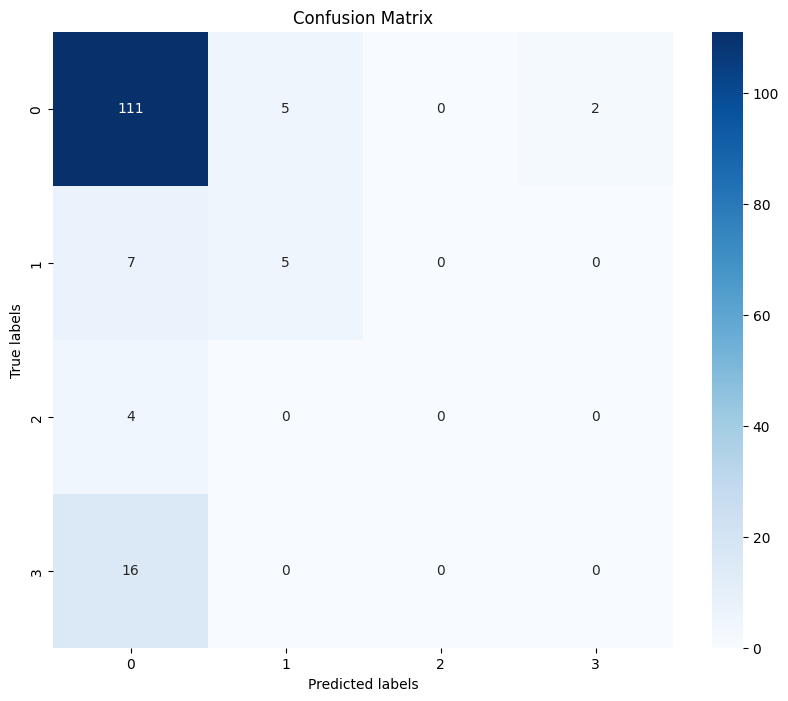

In [19]:
conf_matrix = confusion_matrix(y_test, predicted_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='g', cmap='Blues', xticklabels=[0, 1, 2, 3], yticklabels=[0, 1, 2, 3])
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

In [20]:
evl=d_w_model.evaluate(X_test,y_test)

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7869 - loss: 1.7168  
